In [1]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- CONFIGURATION: DEFINE THE PARAMETERS
-- 
-- 
-- 
----------------------------------------------------------------------

In [2]:
-- define options
opt = {
    size = 'small',      -- how many samples do we load: small | full | extra
    visualize = true,    -- visualize input data and weights during training
    model = 'convnet',   -- type of model to construct: linear | mlp | convnet
    loss = 'nll',        -- type of loss function to minimize: nll | mse | margin
    plot = false,        -- live plot
    save = 'results',    -- subdirectory to save/log experiments in
    optimization = 'CG', -- optimization method: SGD | ASGD | CG | LBFGS
    learningRage = 1e-3, -- learning rate at t=0
    batchSize = 1,       -- mini-batch size (1 = pure stochastic)
    weightDecay = 0,     -- weight decay (SGD only)
    momentum = 0,        -- momentum (SGD only)
    t0 = 1,              -- start averaging at t0 (ASGD only), in nb of epochs
    maxIter = 2,         -- maximum nb of iterations for CG and LBFGS
    type = 'double',     -- double | float | cuda,
    threads = 1,         -- runtime threads
    seed = 1             -- initialize random number generator
}

-- nb of threads and fixed seed (for repeatable experiments)
if opt.type == 'float' then
   print('==> switching to floats')
   torch.setdefaulttensortype('torch.FloatTensor')
elseif opt.type == 'cuda' then
   print('==> switching to CUDA')
   require 'cunn'
   torch.setdefaulttensortype('torch.FloatTensor')
end
torch.setnumthreads(opt.threads)
torch.manualSeed(opt.seed)

In [3]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- STEP 1: DATA
-- 
-- 
-- 
----------------------------------------------------------------------

In [4]:
----------------------------------------------------------------------
-- This script demonstrates how to load the (SVHN) House Numbers 
-- training data, and pre-process it to facilitate learning.
--
-- The SVHN is a typicaly example of supervised training dataset. 
-- The problem to solve is a 10-class classification problem, similar
-- to the quite known MNIST challenge.
--
-- It's a good idea to run this script with the interactive mode:
-- $ torch -i 1_data.lua
-- this will give you a Torch interpreter at the end, that you
-- can use to analyze/visualize the data you've just loaded.
--
-- Clement Farabet
----------------------------------------------------------------------

require 'torch'   -- torch
require 'image'   -- for color transforms
require 'nn'      -- provides a normalization operator

In [5]:
----------------------------------------------------------------------
-- parse command line arguments
if not opt then
   print '==> processing options'
   cmd = torch.CmdLine()
   cmd:text()
   cmd:text('SVHN Dataset Preprocessing')
   cmd:text()
   cmd:text('Options:')
   cmd:option('-size', 'small', 'how many samples do we load: small | full | extra')
   cmd:option('-visualize', true, 'visualize input data and weights during training')
   cmd:text()
   opt = cmd:parse(arg or {})
end

In [6]:
----------------------------------------------------------------------
print '==> downloading dataset'

-- Here we download dataset files. 

-- Note: files were converted from their original Matlab format
-- to Torch's internal format using the mattorch package. The
-- mattorch package allows 1-to-1 conversion between Torch and Matlab
-- files.

-- The SVHN dataset contains 3 files:
--    + train: training data
--    + test:  test data
--    + extra: extra training data

-- By default, we don't use the extra training data, as it is much 
-- more time consuming

www = 'http://torch7.s3-website-us-east-1.amazonaws.com/data/housenumbers/'

train_file = 'train_32x32.t7'
test_file = 'test_32x32.t7'
extra_file = 'extra_32x32.t7'

if not paths.filep(train_file) then
   os.execute('wget ' .. www .. train_file)
end
if not paths.filep(test_file) then
   os.execute('wget ' .. www .. test_file)
end
if opt.size == 'extra' and not paths.filep(extra_file) then
   os.execute('wget ' .. www .. extra_file)   
end

==> downloading dataset	


In [7]:
----------------------------------------------------------------------
-- training/test size

if opt.size == 'extra' then
   print '==> using extra training data'
   trsize = 73257 + 531131
   tesize = 26032
elseif opt.size == 'full' then
   print '==> using regular, full training data'
   trsize = 73257
   tesize = 26032
elseif opt.size == 'small' then
   print '==> using reduced training data, for fast experiments'
   trsize = 10000
   tesize = 2000
end

In [8]:
----------------------------------------------------------------------
print '==> loading dataset'

-- We load the dataset from disk, and re-arrange it to be compatible
-- with Torch's representation. Matlab uses a column-major representation,
-- Torch is row-major, so we just have to transpose the data.

-- Note: the data, in X, is 4-d: the 1st dim indexes the samples, the 2nd
-- dim indexes the color channels (RGB), and the last two dims index the
-- height and width of the samples.

loaded = torch.load(train_file,'ascii')
trainData = {
   data = loaded.X:transpose(3,4),
   labels = loaded.y[1],
   size = function() return trsize end
}

-- If extra data is used, we load the extra file, and then
-- concatenate the two training sets.

-- Torch's slicing syntax can be a little bit frightening. I've
-- provided a little tutorial on this, in this same directory:
-- A_slicing.lua

if opt.size == 'extra' then
   loaded = torch.load(extra_file,'ascii')
   trdata = torch.Tensor(trsize,3,32,32)
   trdata[{ {1,(#trainData.data)[1]} }] = trainData.data
   trdata[{ {(#trainData.data)[1]+1,-1} }] = loaded.X:transpose(3,4)
   trlabels = torch.Tensor(trsize)
   trlabels[{ {1,(#trainData.labels)[1]} }] = trainData.labels
   trlabels[{ {(#trainData.labels)[1]+1,-1} }] = loaded.y[1]
   trainData = {
      data = trdata,
      labels = trlabels,
      size = function() return trsize end
   }
end

-- Finally we load the test data.

loaded = torch.load(test_file,'ascii')
testData = {
   data = loaded.X:transpose(3,4),
   labels = loaded.y[1],
   size = function() return tesize end
}

==> loading dataset	


In [9]:
----------------------------------------------------------------------
print '==> preprocessing data'

-- Preprocessing requires a floating point representation (the original
-- data is stored on bytes). Types can be easily converted in Torch, 
-- in general by doing: dst = src:type('torch.TypeTensor'), 
-- where Type=='Float','Double','Byte','Int',... Shortcuts are provided
-- for simplicity (float(),double(),cuda(),...):

trainData.data = trainData.data:float()
testData.data = testData.data:float()

-- We now preprocess the data. Preprocessing is crucial
-- when applying pretty much any kind of machine learning algorithm.

-- For natural images, we use several intuitive tricks:
--   + images are mapped into YUV space, to separate luminance information
--     from color information
--   + the luminance channel (Y) is locally normalized, using a contrastive
--     normalization operator: for each neighborhood, defined by a Gaussian
--     kernel, the mean is suppressed, and the standard deviation is normalized
--     to one.
--   + color channels are normalized globally, across the entire dataset;
--     as a result, each color component has 0-mean and 1-norm across the dataset.

-- Convert all images to YUV
print '==> preprocessing data: colorspace RGB -> YUV'
for i = 1,trainData:size() do
   trainData.data[i] = image.rgb2yuv(trainData.data[i])
end
for i = 1,testData:size() do
   testData.data[i] = image.rgb2yuv(testData.data[i])
end

-- Name channels for convenience
channels = {'y','u','v'}

==> preprocessing data	


==> preprocessing data: colorspace RGB -> YUV	


In [10]:
-- Normalize each channel, and store mean/std
-- per channel. These values are important, as they are part of
-- the trainable parameters. At test time, test data will be normalized
-- using these values.
print '==> preprocessing data: normalize each feature (channel) globally'
mean = {}
std = {}
for i,channel in ipairs(channels) do
   -- normalize each channel globally:
   mean[i] = trainData.data[{ {},i,{},{} }]:mean()
   std[i] = trainData.data[{ {},i,{},{} }]:std()
   trainData.data[{ {},i,{},{} }]:add(-mean[i])
   trainData.data[{ {},i,{},{} }]:div(std[i])
end

-- Normalize test data, using the training means/stds
for i,channel in ipairs(channels) do
   -- normalize each channel globally:
   testData.data[{ {},i,{},{} }]:add(-mean[i])
   testData.data[{ {},i,{},{} }]:div(std[i])
end

==> preprocessing data: normalize each feature (channel) globally	


In [11]:
-- Local normalization
print '==> preprocessing data: normalize all three channels locally'

-- Define the normalization neighborhood:
neighborhood = image.gaussian1D(13)

-- Define our local normalization operator (It is an actual nn module, 
-- which could be inserted into a trainable model):
normalization = nn.SpatialContrastiveNormalization(1, neighborhood, 1):float()

-- Normalize all channels locally:
for c in ipairs(channels) do
   for i = 1,trainData:size() do
      trainData.data[{ i,{c},{},{} }] = normalization:forward(trainData.data[{ i,{c},{},{} }])
   end
   for i = 1,testData:size() do
      testData.data[{ i,{c},{},{} }] = normalization:forward(testData.data[{ i,{c},{},{} }])
   end
end

==> preprocessing data: normalize all three channels locally	


In [12]:
----------------------------------------------------------------------
print '==> verify statistics'

-- It's always good practice to verify that data is properly
-- normalized.

for i,channel in ipairs(channels) do
   trainMean = trainData.data[{ {},i }]:mean()
   trainStd = trainData.data[{ {},i }]:std()

   testMean = testData.data[{ {},i }]:mean()
   testStd = testData.data[{ {},i }]:std()

   print('training data, '..channel..'-channel, mean: ' .. trainMean)
   print('training data, '..channel..'-channel, standard deviation: ' .. trainStd)

   print('test data, '..channel..'-channel, mean: ' .. testMean)
   print('test data, '..channel..'-channel, standard deviation: ' .. testStd)
end

==> verify statistics	


training data, y-channel, mean: -0.0063139642417579	
training data, y-channel, standard deviation: 0.94085703691789	
test data, y-channel, mean: 0.064013399322829	
test data, y-channel, standard deviation: 1.071276998661	


training data, u-channel, mean: 0.21264134740817	
training data, u-channel, standard deviation: 0.78796428969242	
test data, u-channel, mean: 0.26287914429573	
test data, u-channel, standard deviation: 0.9165508939245	


training data, v-channel, mean: 0.22919727886955	
training data, v-channel, standard deviation: 0.74868942250143	
test data, v-channel, mean: 0.23141433884277	
test data, v-channel, standard deviation: 0.89402614255712	


==> visualizing data	


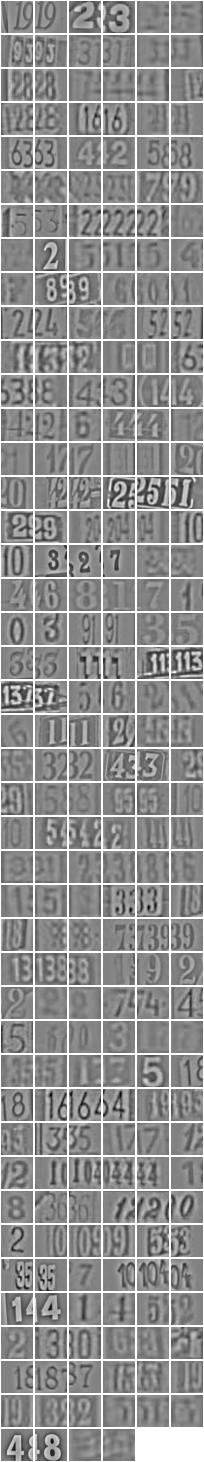

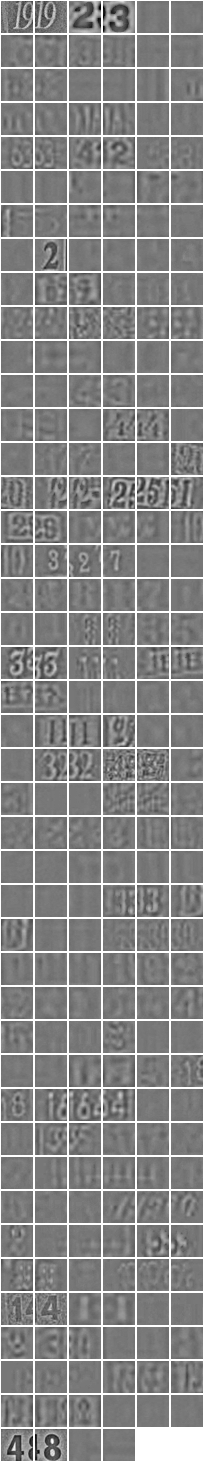

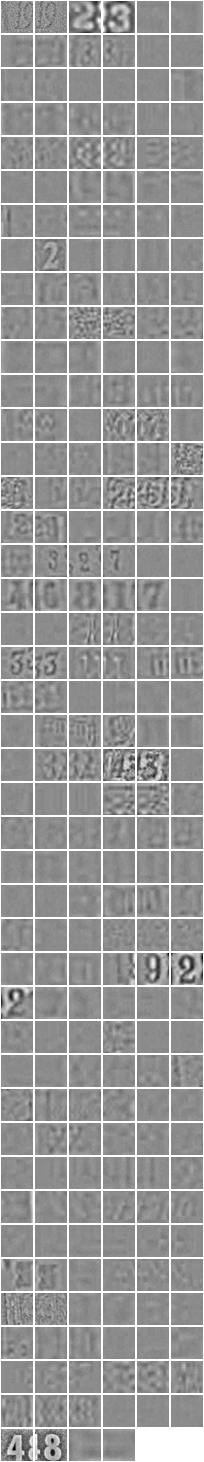

In [13]:
----------------------------------------------------------------------
print '==> visualizing data'

-- Visualization is quite easy, using itorch.image().

if opt.visualize then
   if itorch then
   first256Samples_y = trainData.data[{ {1,256},1 }]
   first256Samples_u = trainData.data[{ {1,256},2 }]
   first256Samples_v = trainData.data[{ {1,256},3 }]
   itorch.image(first256Samples_y)
   itorch.image(first256Samples_u)
   itorch.image(first256Samples_v)
   else
      print("For visualization, run this script in an itorch notebook")
   end
end

In [14]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- STEP 2: MODEL DEFINITION
-- 
-- 
-- 
----------------------------------------------------------------------

In [15]:
----------------------------------------------------------------------
-- This script demonstrates how to define a couple of different
-- models:
--   + linear
--   + 2-layer neural network (MLP)
--   + convolutional network (ConvNet)
--
-- It's a good idea to run this script with the interactive mode:
-- $ torch -i 2_model.lua
-- this will give you a Torch interpreter at the end, that you
-- can use to play with the model.
--
-- Clement Farabet
----------------------------------------------------------------------

require 'torch'   -- torch
require 'image'   -- for image transforms
require 'nn'      -- provides all sorts of trainable modules/layers

In [16]:
----------------------------------------------------------------------
-- parse command line arguments
if not opt then
   print '==> processing options'
   cmd = torch.CmdLine()
   cmd:text()
   cmd:text('SVHN Model Definition')
   cmd:text()
   cmd:text('Options:')
   cmd:option('-model', 'convnet', 'type of model to construct: linear | mlp | convnet')
   cmd:option('-visualize', true, 'visualize input data and weights during training')
   cmd:text()
   opt = cmd:parse(arg or {})
end

In [17]:
----------------------------------------------------------------------
print '==> define parameters'

-- 10-class problem
noutputs = 10

-- input dimensions
nfeats = 3
width = 32
height = 32
ninputs = nfeats*width*height

-- number of hidden units (for MLP only):
nhiddens = ninputs / 2

-- hidden units, filter sizes (for ConvNet only):
nstates = {64,64,128}
filtsize = 5
poolsize = 2
normkernel = image.gaussian1D(7)

==> define parameters	


In [18]:
----------------------------------------------------------------------
print '==> construct model'

if opt.model == 'linear' then

   -- Simple linear model
   model = nn.Sequential()
   model:add(nn.Reshape(ninputs))
   model:add(nn.Linear(ninputs,noutputs))

elseif opt.model == 'mlp' then

   -- Simple 2-layer neural network, with tanh hidden units
   model = nn.Sequential()
   model:add(nn.Reshape(ninputs))
   model:add(nn.Linear(ninputs,nhiddens))
   model:add(nn.Tanh())
   model:add(nn.Linear(nhiddens,noutputs))

elseif opt.model == 'convnet' then

   if opt.type == 'cuda' then
      -- a typical modern convolution network (conv+relu+pool)
      model = nn.Sequential()

      -- stage 1 : filter bank -> squashing -> L2 pooling -> normalization
      model:add(nn.SpatialConvolutionMM(nfeats, nstates[1], filtsize, filtsize))
      model:add(nn.ReLU())
      model:add(nn.SpatialMaxPooling(poolsize,poolsize,poolsize,poolsize))

      -- stage 2 : filter bank -> squashing -> L2 pooling -> normalization
      model:add(nn.SpatialConvolutionMM(nstates[1], nstates[2], filtsize, filtsize))
      model:add(nn.ReLU())
      model:add(nn.SpatialMaxPooling(poolsize,poolsize,poolsize,poolsize))

      -- stage 3 : standard 2-layer neural network
      model:add(nn.View(nstates[2]*filtsize*filtsize))
      model:add(nn.Dropout(0.5))
      model:add(nn.Linear(nstates[2]*filtsize*filtsize, nstates[3]))
      model:add(nn.ReLU())
      model:add(nn.Linear(nstates[3], noutputs))

   else
      -- a typical convolutional network, with locally-normalized hidden
      -- units, and L2-pooling

      -- Note: the architecture of this convnet is loosely based on Pierre Sermanet's
      -- work on this dataset (http://arxiv.org/abs/1204.3968). In particular
      -- the use of LP-pooling (with P=2) has a very positive impact on
      -- generalization. Normalization is not done exactly as proposed in
      -- the paper, and low-level (first layer) features are not fed to
      -- the classifier.

      model = nn.Sequential()

      -- stage 1 : filter bank -> squashing -> L2 pooling -> normalization
      model:add(nn.SpatialConvolutionMM(nfeats, nstates[1], filtsize, filtsize))
      model:add(nn.Tanh())
      model:add(nn.SpatialLPPooling(nstates[1],2,poolsize,poolsize,poolsize,poolsize))
      model:add(nn.SpatialSubtractiveNormalization(nstates[1], normkernel))

      -- stage 2 : filter bank -> squashing -> L2 pooling -> normalization
      model:add(nn.SpatialConvolutionMM(nstates[1], nstates[2], filtsize, filtsize))
      model:add(nn.Tanh())
      model:add(nn.SpatialLPPooling(nstates[2],2,poolsize,poolsize,poolsize,poolsize))
      model:add(nn.SpatialSubtractiveNormalization(nstates[2], normkernel))

      -- stage 3 : standard 2-layer neural network
      model:add(nn.Reshape(nstates[2]*filtsize*filtsize))
      model:add(nn.Linear(nstates[2]*filtsize*filtsize, nstates[3]))
      model:add(nn.Tanh())
      model:add(nn.Linear(nstates[3], noutputs))
   end
else

   error('unknown -model')

end

==> construct model	


In [19]:
----------------------------------------------------------------------
print '==> here is the model:'
print(model)

==> here is the model:	
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> output]
  (1): nn.SpatialConvolutionMM
  (2): nn.Tanh
  (3): nn.Sequential {
    [input -> (1) -> (2) -> (3) -> (4) -> output]
    (1): nn.Square
    (2): nn.SpatialAveragePooling
    (3): nn.MulConstant
    (4): nn.Sqrt
  }
  (4): nn.SpatialSubtractiveNormalization
  (5): nn.SpatialConvolutionMM
  (6): nn.Tanh
  (7): nn.Sequential {
    [input -> (1) -> (2) -> (3) -> (4) -> output]
    (1): nn.Square
    (2): nn.SpatialAveragePooling
    (3): nn.MulConstant
    (4): nn.Sqrt
  }
  (8): nn.SpatialSubtractiveNormalization
  (9): nn.Reshape(1600)
  (10): nn.Linear(1600 -> 128)
  (11): nn.Tanh
  (12): nn.Linear(128 -> 10)
}
{
  gradInput : DoubleTensor - empty
  modules : 
    {
      1 : 
        nn.SpatialConvolutionMM
        {
          dH : 1
          dW : 1
          nOutputPlane : 64
          output : DoubleTensor - empty
          gradInput : 

    kH : 5
        }
      2 : 
        nn.Tanh
        {
          gradInput : DoubleTensor - empty
          output : DoubleTensor - empty
        }
      3 : 
        nn.Sequential {
          [input -> (1) -> (2) -> (3) -> (4) -> output]
          (1): nn.Square
          (2): nn.SpatialAveragePooling
          (3): nn.MulConstant
          (4): nn.Sqrt
        }
        {
          dH : 2
          dW : 2
          kW : 2
          gradInput : DoubleTensor - empty
          modules : 
            {
              1 : 
                nn.Square
                {
                  gradInput : DoubleTensor - empty
                  output : DoubleTensor - empty
                }
              2 : 
                nn.SpatialAveragePooling
                {
                  dH : 2
                  dW : 2
                  kW : 2
                  gradInput : DoubleTensor - empty
                  divide : true
                  output : DoubleTensor - empty
                  kH : 2
  

           3 : 
                nn.MulConstant
                {
                  gradInput : DoubleTensor - empty
                  inplace : false
                  constant_scalar : 4
                  output : DoubleTensor - empty
                }
              4 : 
                nn.Sqrt
                {
                  gradInput : DoubleTensor - empty
                  eps : 0
                  output : DoubleTensor - empty
                }
            }
          kH : 2
          output : DoubleTensor - empty
        }
      4 : 
        nn.SpatialSubtractiveNormalization
        {
          coef : DoubleTensor - size: 1x1x1
         

 kernel : DoubleTensor - size: 7
          nInputPlane : 64
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          divider : 
            nn.CDivTable
            {
              gradInput : table: 0x41ef4c18
              output : DoubleTensor - empty
            }
          meanestimator : 
            nn.Sequential {
              [input -> (1) -> (2) -> (3) -> (4) -> output]
              (1): nn.SpatialZeroPadding(l=3,r=3,t=3,b=3)
              (2): nn.SpatialConvolutionMap
              (3): nn.SpatialConvolution
              (4): nn.Replicate
            }
            {
              gradInput : DoubleTensor - empty
              modules : 
                {
                  1 : nn.SpatialZeroPadding(l=3,r=3,t=3,b=3)
                  2 : nn.SpatialConvolutionMap
                  3 : nn.SpatialConvolution
                  4 : nn.Replicate
                }
              output : DoubleTensor - empty
            }
          subtractor : 


{
          dH : 1
          dW : 1
          nOutputPlane : 64
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          finput : DoubleTensor - empty
          fgradInput : DoubleTensor - empty
          gradBias : DoubleTensor - size: 64
          weight : DoubleTensor - size: 64x1600
          bias : DoubleTensor - size: 64
          gradWeight : DoubleTensor - size: 64x1600
          padding : 0
          nInputPlane : 64
          kW : 5
          kH : 5
        }
      6 : 
        nn.Tanh
        {
          gradInput : DoubleTensor - empty
          output : DoubleTensor - empty
        }
      7 : 
        nn.Sequential {
          [input -> (1) -> (2) -> (3) -> (4) -> output]
          (1): nn.Square
          (2): nn.SpatialAveragePooling
          (3): nn.MulConstant
          (4): nn.Sqrt
        }
        {
          dH : 2
          dW : 2
          kW : 2
          gradInput : DoubleTensor - empty
          modules : 
            {
  

  nn.SpatialAveragePooling
                {
                  dH : 2
                  dW : 2
                  kW : 2
                  gradInput : DoubleTensor - empty
                  divide : true
                  output : DoubleTensor - empty
                  kH : 2
                }
              3 : 
                nn.MulConstant
                {
                  gradInput : DoubleTensor - empty
                  inplace : false
                  constant_scalar : 4
                  output : DoubleTensor - empty
                }
              4 : 
                nn.Sqrt
                {
                  gradInput : DoubleTensor - empty
                  eps : 0
          

        output : DoubleTensor - empty
                }
            }
          kH : 2
          output : DoubleTensor - empty
        }
      8 : 
        nn.SpatialSubtractiveNormalization
        {
          coef : DoubleTensor - size: 1x1x1
          kernel : DoubleTensor - size: 7
          nInputPlane : 64
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          divider : 
            nn.CDivTable
            {
              gradInput : table: 0x41e53580
              output : DoubleTensor - empty
            }
          meanestimator : 
            nn.Sequential {
              [input -> (1) -> (2) -> (3) -> (4) -> output]
              (1): nn.SpatialZeroPadding(l=3,r=3,t=3,b=3)
              (2): nn.SpatialConvolutionMap
              (3): nn.SpatialConvolution
              (4): nn.Replicate
            }
            {
              gradInput : DoubleTensor - empty
              modules : 
                {


                  1 : nn.SpatialZeroPadding(l=3,r=3,t=3,b=3)
                  2 : nn.SpatialConvolutionMap
                  3 : nn.SpatialConvolution
                  4 : nn.Replicate
                }
              output : DoubleTensor - empty
            }
          subtractor : 
            nn.CSubTable
            {
              gradInput : table: 0x41e43178
              output : DoubleTensor - empty
            }
        }
      9 : 
        nn.Reshape(1600)
        {
          nelement : 1600
          _input : DoubleTensor - empty
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          size : LongStorage - size: 1
          _gradOutput : DoubleTensor - empty
          batchsize : LongStorage - size: 2
        }
      10 : 
        nn.Linear(1600 -> 128)
        {
      

    gradBias : DoubleTensor - size: 128
          weight : DoubleTensor - size: 128x1600
          bias : DoubleTensor - size: 128
          gradInput : DoubleTensor - empty
          gradWeight : DoubleTensor - size: 128x1600
          output : DoubleTensor - empty
        }
      11 : 
        nn.Tanh
        {
          gradInput : DoubleTensor - empty
          output : DoubleTensor - empty
        }
      12 : 
        nn.Linear(128 -> 10)
        {
          gradBias : DoubleTensor - size: 10
          weight : DoubleTensor - size: 10x128
          bias : DoubleTensor - size: 10
          gradInput : DoubleTensor - empty
          gradWeight : DoubleTensor - size: 10x128
          output : DoubleTensor - empty
        }
    }
  output : DoubleTensor - empty
}


==> visualizing ConvNet filters	
Layer 1 filters:	


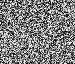

Layer 2 filters:	


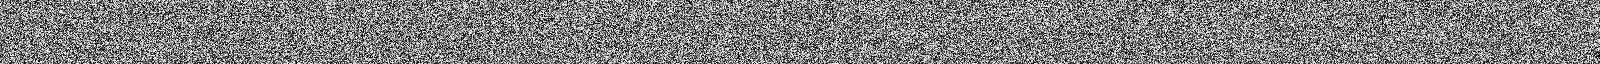

In [20]:
----------------------------------------------------------------------
-- Visualization is quite easy, using itorch.image().

if opt.visualize then
   if opt.model == 'convnet' then
      if itorch then
	 print '==> visualizing ConvNet filters'
	 print('Layer 1 filters:')
	 itorch.image(model:get(1).weight)
	 print('Layer 2 filters:')
	 itorch.image(model:get(5).weight)
      else
	 print '==> To visualize filters, start the script in itorch notebook'
      end
   end
end

In [21]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- STEP 3: MODEL DEFINITION
-- 
-- 
-- 
----------------------------------------------------------------------

In [22]:
----------------------------------------------------------------------
-- This script demonstrates how to define a couple of different
-- loss functions:
--   + negative-log likelihood, using log-normalized output units (SoftMax)
--   + mean-square error
--   + margin loss (SVM-like)
--
-- Clement Farabet
----------------------------------------------------------------------

require 'torch'   -- torch
require 'nn'      -- provides all sorts of loss functions

In [23]:
----------------------------------------------------------------------
-- parse command line arguments
if not opt then
   print '==> processing options'
   cmd = torch.CmdLine()
   cmd:text()
   cmd:text('SVHN Loss Function')
   cmd:text()
   cmd:text('Options:')
   cmd:option('-loss', 'nll', 'type of loss function to minimize: nll | mse | margin')
   cmd:text()
   opt = cmd:parse(arg or {})

   -- to enable self-contained execution:
   model = nn.Sequential()
end

-- 10-class problem
noutputs = 10

In [24]:
----------------------------------------------------------------------
print '==> define loss'

if opt.loss == 'margin' then

   -- This loss takes a vector of classes, and the index of
   -- the grountruth class as arguments. It is an SVM-like loss
   -- with a default margin of 1.

   criterion = nn.MultiMarginCriterion()

elseif opt.loss == 'nll' then

   -- This loss requires the outputs of the trainable model to
   -- be properly normalized log-probabilities, which can be
   -- achieved using a softmax function

   model:add(nn.LogSoftMax())

   -- The loss works like the MultiMarginCriterion: it takes
   -- a vector of classes, and the index of the grountruth class
   -- as arguments.

   criterion = nn.ClassNLLCriterion()

elseif opt.loss == 'mse' then

   -- for MSE, we add a tanh, to restrict the model's output
   model:add(nn.Tanh())

   -- The mean-square error is not recommended for classification
   -- tasks, as it typically tries to do too much, by exactly modeling
   -- the 1-of-N distribution. For the sake of showing more examples,
   -- we still provide it here:

   criterion = nn.MSECriterion()
   criterion.sizeAverage = false

   -- Compared to the other losses, the MSE criterion needs a distribution
   -- as a target, instead of an index. Indeed, it is a regression loss!
   -- So we need to transform the entire label vectors:

   if trainData then
      -- convert training labels:
      local trsize = (#trainData.labels)[1]
      local trlabels = torch.Tensor( trsize, noutputs )
      trlabels:fill(-1)
      for i = 1,trsize do
         trlabels[{ i,trainData.labels[i] }] = 1
      end
      trainData.labels = trlabels

      -- convert test labels
      local tesize = (#testData.labels)[1]
      local telabels = torch.Tensor( tesize, noutputs )
      telabels:fill(-1)
      for i = 1,tesize do
         telabels[{ i,testData.labels[i] }] = 1
      end
      testData.labels = telabels
   end

else

   error('unknown -loss')

end

==> define loss	


In [25]:
----------------------------------------------------------------------
print '==> here is the loss function:'
print(criterion)

==> here is the loss function:	
nn.ClassNLLCriterion
{
  gradInput : DoubleTensor - empty
  outputTensor : DoubleTensor - size: 1
  sizeAverage : true
  output : 0
}


In [26]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- STEP 4: TRAINING PROCEDURE
-- 
-- 
-- 
----------------------------------------------------------------------

In [27]:
----------------------------------------------------------------------
-- This script demonstrates how to define a training procedure,
-- irrespective of the model/loss functions chosen.
--
-- It shows how to:
--   + construct mini-batches on the fly
--   + define a closure to estimate (a noisy) loss
--     function, as well as its derivatives wrt the parameters of the
--     model to be trained
--   + optimize the function, according to several optmization
--     methods: SGD, L-BFGS.
--
-- Clement Farabet
----------------------------------------------------------------------

require 'torch'   -- torch
require 'xlua'    -- xlua provides useful tools, like progress bars
require 'optim'   -- an optimization package, for online and batch methods

In [28]:
----------------------------------------------------------------------
-- parse command line arguments
if not opt then
   print '==> processing options'
   cmd = torch.CmdLine()
   cmd:text()
   cmd:text('SVHN Training/Optimization')
   cmd:text()
   cmd:text('Options:')
   cmd:option('-save', 'results', 'subdirectory to save/log experiments in')
   cmd:option('-visualize', false, 'visualize input data and weights during training')
   cmd:option('-plot', false, 'live plot')
   cmd:option('-optimization', 'SGD', 'optimization method: SGD | ASGD | CG | LBFGS')
   cmd:option('-learningRate', 1e-3, 'learning rate at t=0')
   cmd:option('-batchSize', 1, 'mini-batch size (1 = pure stochastic)')
   cmd:option('-weightDecay', 0, 'weight decay (SGD only)')
   cmd:option('-momentum', 0, 'momentum (SGD only)')
   cmd:option('-t0', 1, 'start averaging at t0 (ASGD only), in nb of epochs')
   cmd:option('-maxIter', 2, 'maximum nb of iterations for CG and LBFGS')
   cmd:text()
   opt = cmd:parse(arg or {})
end

In [29]:
----------------------------------------------------------------------
-- CUDA?
if opt.type == 'cuda' then
   model:cuda()
   criterion:cuda()
end

In [30]:
----------------------------------------------------------------------
print '==> defining some tools'

-- classes
classes = {'1','2','3','4','5','6','7','8','9','0'}

-- This matrix records the current confusion across classes
confusion = optim.ConfusionMatrix(classes)

-- Log results to files
trainLogger = optim.Logger(paths.concat(opt.save, 'train.log'))
testLogger = optim.Logger(paths.concat(opt.save, 'test.log'))

-- Retrieve parameters and gradients:
-- this extracts and flattens all the trainable parameters of the mode
-- into a 1-dim vector
if model then
   parameters,gradParameters = model:getParameters()
end

==> defining some tools	


In [31]:
----------------------------------------------------------------------
print '==> configuring optimizer'

if opt.optimization == 'CG' then
   optimState = {
      maxIter = opt.maxIter
   }
   optimMethod = optim.cg

elseif opt.optimization == 'LBFGS' then
   optimState = {
      learningRate = opt.learningRate,
      maxIter = opt.maxIter,
      nCorrection = 10
   }
   optimMethod = optim.lbfgs

elseif opt.optimization == 'SGD' then
   optimState = {
      learningRate = opt.learningRate,
      weightDecay = opt.weightDecay,
      momentum = opt.momentum,
      learningRateDecay = 1e-7
   }
   optimMethod = optim.sgd

elseif opt.optimization == 'ASGD' then
   optimState = {
      eta0 = opt.learningRate,
      t0 = trsize * opt.t0
   }
   optimMethod = optim.asgd

else
   error('unknown optimization method')
end

==> configuring optimizer	


In [32]:
----------------------------------------------------------------------
print '==> defining training procedure'

function train()

   -- epoch tracker
   epoch = epoch or 1

   -- local vars
   local time = sys.clock()

   -- set model to training mode (for modules that differ in training and testing, like Dropout)
   model:training()

   -- shuffle at each epoch
   shuffle = torch.randperm(trsize)

   -- do one epoch
   print('==> doing epoch on training data:')
   print("==> online epoch # " .. epoch .. ' [batchSize = ' .. opt.batchSize .. ']')
   for t = 1,trainData:size(),opt.batchSize do
      -- disp progress
      xlua.progress(t, trainData:size())

      -- create mini batch
      local inputs = {}
      local targets = {}
      for i = t,math.min(t+opt.batchSize-1,trainData:size()) do
         -- load new sample
         local input = trainData.data[shuffle[i]]
         local target = trainData.labels[shuffle[i]]
         if opt.type == 'double' then input = input:double()
         elseif opt.type == 'cuda' then input = input:cuda() end
         table.insert(inputs, input)
         table.insert(targets, target)
      end

      -- create closure to evaluate f(X) and df/dX
      local feval = function(x)
                       -- get new parameters
                       if x ~= parameters then
                          parameters:copy(x)
                       end

                       -- reset gradients
                       gradParameters:zero()

                       -- f is the average of all criterions
                       local f = 0

                       -- evaluate function for complete mini batch
                       for i = 1,#inputs do
                          -- estimate f
                          local output = model:forward(inputs[i])
                          local err = criterion:forward(output, targets[i])
                          f = f + err

                          -- estimate df/dW
                          local df_do = criterion:backward(output, targets[i])
                          model:backward(inputs[i], df_do)

                          -- update confusion
                          confusion:add(output, targets[i])
                       end

                       -- normalize gradients and f(X)
                       gradParameters:div(#inputs)
                       f = f/#inputs

                       -- return f and df/dX
                       return f,gradParameters
                    end

      -- optimize on current mini-batch
      if optimMethod == optim.asgd then
         _,_,average = optimMethod(feval, parameters, optimState)
      else
         optimMethod(feval, parameters, optimState)
      end
   end

   -- time taken
   time = sys.clock() - time
   time = time / trainData:size()
   print("\n==> time to learn 1 sample = " .. (time*1000) .. 'ms')

   -- print confusion matrix
   print(confusion)

   -- update logger/plot
   trainLogger:add{['% mean class accuracy (train set)'] = confusion.totalValid * 100}
   if opt.plot then
      trainLogger:style{['% mean class accuracy (train set)'] = '-'}
      trainLogger:plot()
   end

   -- save/log current net
   local filename = paths.concat(opt.save, 'model.net')
   os.execute('mkdir -p ' .. sys.dirname(filename))
   print('==> saving model to '..filename)
   torch.save(filename, model)

   -- next epoch
   confusion:zero()
   epoch = epoch + 1
end

==> defining training procedure	


In [33]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- STEP 5: TEST THE MODEL
-- 
-- 
-- 
----------------------------------------------------------------------

In [34]:
----------------------------------------------------------------------
-- This script implements a test procedure, to report accuracy
-- on the test data. Nothing fancy here...
--
-- Clement Farabet
----------------------------------------------------------------------

require 'torch'   -- torch
require 'xlua'    -- xlua provides useful tools, like progress bars
require 'optim'   -- an optimization package, for online and batch methods

In [35]:
----------------------------------------------------------------------
print '==> defining test procedure'

-- test function
function test()
   -- local vars
   local time = sys.clock()

   -- averaged param use?
   if average then
      cachedparams = parameters:clone()
      parameters:copy(average)
   end

   -- set model to evaluate mode (for modules that differ in training and testing, like Dropout)
   model:evaluate()

   -- test over test data
   print('==> testing on test set:')
   for t = 1,testData:size() do
      -- disp progress
      xlua.progress(t, testData:size())

      -- get new sample
      local input = testData.data[t]
      if opt.type == 'double' then input = input:double()
      elseif opt.type == 'cuda' then input = input:cuda() end
      local target = testData.labels[t]

      -- test sample
      local pred = model:forward(input)
      confusion:add(pred, target)
   end

   -- timing
   time = sys.clock() - time
   time = time / testData:size()
   print("\n==> time to test 1 sample = " .. (time*1000) .. 'ms')

   -- print confusion matrix
   print(confusion)

   -- update log/plot
   testLogger:add{['% mean class accuracy (test set)'] = confusion.totalValid * 100}
   if opt.plot then
      testLogger:style{['% mean class accuracy (test set)'] = '-'}
      testLogger:plot()
   end

   -- averaged param use?
   if average then
      -- restore parameters
      parameters:copy(cachedparams)
   end
   
   -- next iteration:
   confusion:zero()
end

==> defining test procedure	


In [36]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- EXECUTE!
-- 
-- 
-- 
----------------------------------------------------------------------

In [ ]:
while true
do
   train()
   test()
end

==> doing epoch on training data:	
==> online epoch # 1 [batchSize = 1]	
Progress: 1 / 10000	


Progress: 258 / 10000	


Progress: 482 / 10000	


Progress: 683 / 10000	


Progress: 901 / 10000	


Progress: 1129 / 10000	


Progress: 1328 / 10000	


Progress: 1550 / 10000	


Progress: 1773 / 10000	


Progress: 1996 / 10000	


Progress: 2227 / 10000	


Progress: 2455 / 10000	


Progress: 2597 / 10000	


Progress: 2785 / 10000	


Progress: 3003 / 10000	


Progress: 3212 / 10000	


Progress: 3418 / 10000	


Progress: 3653 / 10000	


Progress: 3838 / 10000	


Progress: 4062 / 10000	


Progress: 4303 / 10000	


Progress: 4525 / 10000	


Progress: 4757 / 10000	


Progress: 4997 / 10000	


Progress: 5229 / 10000	


Progress: 5433 / 10000	


Progress: 5637 / 10000	


Progress: 5878 / 10000	


Progress: 6097 / 10000	


Progress: 6337 / 10000	


Progress: 6581 / 10000	


Progress: 6821 / 10000	


Progress: 7053 / 10000	


Progress: 7284 / 10000	


Progress: 7480 / 10000	


Progress: 7726 / 10000	


Progress: 7969 / 10000	


Progress: 8215 / 10000	


Progress: 8460 / 10000	


Progress: 8707 / 10000	


Progress: 8948 / 10000	


Progress: 9184 / 10000	


Progress: 9429 / 10000	


Progress: 9672 / 10000	


Progress: 9917 / 10000	



==> time to learn 1 sample = 66.812364697456ms	
ConfusionMatrix:
[[    6019      76      61     151      69      38     116      17      24      68]   90.661% 	[class: 1]
 [     105    4494      57      81      48      26     106      15      53      40]   89.433% 	[class: 2]
 [     163     133    3244      73     292      62      37      37      71      40]   78.131% 	[class: 3]
 [     232     125      46    3078      76      29      23      37      48      38]   82.476% 	[class: 4]
 [      70      28     147      63    3249     141      12      14      32      13]   86.203% 	[class: 5]
 [      47      52     108      72     185    2246      15      98      29      64]   77.023% 	[class: 6]
 [     210     154      55      25      29      12    2218       5      13      22]   80.860% 	[class: 7]
 [     108      98     181      92      67     137      28    1729      78      87]   66.372% 	[class: 8]
 [      55      88      54      97      79      36      16      30    2144      58]   

  mat : FloatTensor - size: 10x10
  averageUnionValid : 0.69742550253868
  _targ_idx : LongTensor - empty
  averageValid : 0.8144950568676
  classes : 
    {
      1 : 1
      2 : 2
      3 : 3
      4 : 4
      5 : 5
      6 : 6
      7 : 7
      8 : 8
      9 : 9
      10 : 0
    }
  _prediction : FloatTensor - size: 10
  _pred_idx : LongTensor - size: 1
  nclasses : 10
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 10
  totalValid : 0.829854487983
}


==> saving model to /data/2_supervised/results/model.net	


==> testing on test set:	


Progress: 1303 / 2000	



==> time to test 1 sample = 7.1792004108429ms	


ConfusionMatrix:
[[     329       4       5      14       2       0      14       2       3       5]   87.037% 	[class: 1]
 [       5     245      23       2       3       1      12       8       3       0]   81.126% 	[class: 2]
 [      12       3     185       3       4       7       2       8      11       1]   78.390% 	[class: 3]
 [      12       3       4     159       4       2       4       3       5       3]   79.899% 	[class: 4]
 [       1       0      17       3     117      23       0       8       0       2]   68.421% 	[class: 5]
 [       3       2       4       0       1     118       4      13       1       6]   77.632% 	[class: 6]
 [       4       5       3       1       2       0     141       1       1       1]   88.679% 	[class: 7]
 [       2       1      11       0       0       6       3     108       5       2]   78.261% 	[class: 8]
 [       1       8       4       2       0       1       6       7      91       7]   71.654% 	[class: 9]
 [       4       1       6   

Progress: 146 / 10000	


Progress: 375 / 10000	


Progress: 617 / 10000	
